In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline

%run bandit_definitions.py
%run algorithms.py
%run sim_utilities.py

# Anon Bandit

In [3]:
np.random.seed(7)

K, M = 15, 4
cdistrib = np.random.rand(M)
cdistrib[0] = 0
cdistrib /= np.sum(cdistrib)

#cdistrib = np.array([1/2, 1/4, 1/4])
#noise = "bernoulli"
p = 0.3
#cdistrib = np.array([1-p, p])

mus = np.random.rand(K,M)
band = AnonBand(K, M, cdistrib, mus)
band_list = [band]

print(mus)
print(band.cdistrib)
print(band.mubar)

def Ntest(t):
    return 10

[[0.97798951 0.53849587 0.50112046 0.07205113]
 [0.26843898 0.4998825  0.67923    0.80373904]
 [0.38094113 0.06593635 0.2881456  0.90959353]
 [0.21338535 0.45212396 0.93120602 0.02489923]
 [0.60054892 0.9501295  0.23030288 0.54848992]
 [0.90912837 0.13316945 0.52341258 0.75040986]
 [0.66901324 0.46775286 0.20484909 0.49076589]
 [0.37238469 0.47740115 0.36589039 0.83791799]
 [0.76864751 0.31399468 0.57262533 0.27604905]
 [0.45284293 0.35297837 0.65739946 0.37035108]
 [0.45909298 0.71932412 0.41299183 0.90642327]
 [0.18045162 0.74111887 0.42237404 0.42645357]
 [0.63437987 0.5229062  0.41488598 0.00142688]
 [0.09226235 0.70939439 0.5243456  0.69616046]
 [0.95546832 0.68291385 0.05312869 0.30885268]]
[0.         0.40164874 0.22577545 0.37257581]
[0.35627139 0.65358436 0.430432   0.40111533 0.63796913 0.45124561
 0.41696974 0.58654461 0.35824951 0.42818183 0.71987043 0.55191744
 0.30422731 0.66268428 0.40135768]


In [11]:
T = 5000
alg_list = [Ignore(K, M, cdistrib, alg=UCB, label='Ignore UCB'),
            #AsFair(K, M, cdistrib, alg=L1OFUL, label="Fair L1OFUL", delta=1./T),
            AsFair(K, M, cdistrib, alg=FairUCB, label="Fair UCB"),
            AsFair(K, M, cdistrib, alg=FairEpsGreedy, label="Fair FTL", epsilon=1),
            #Ignore(K, M, cdistrib, alg=EpsGreedy, label=r'$1/T$-greedy', epsilon=1.),
            Ignore(K, M, cdistrib, alg=EpsGreedy, label='FTL', epsilon=1),
           ]

data_dict={
        'name':'Anon User Bandits',
        'short_name':'anon_band',
        'T':T,
        'band_list':band_list,
        'Ntest':Ntest,
        'alg_list':alg_list,
        'results':None,   
    }

launch(data_dict, fair_reg=False)

Run number  0  /  10
Run number  5  /  10
Ignore UCB  took  2.0579209327697754  total, i.e.  0.20579209327697753  per run
Run number  0  /  10
Run number  5  /  10
Fair UCB  took  6.964136123657227  total, i.e.  0.6964136123657226  per run
Run number  0  /  10
Run number  5  /  10
Fair FTL  took  6.17832088470459  total, i.e.  0.617832088470459  per run
Run number  0  /  10
Run number  5  /  10
FTL  took  1.3184959888458252  total, i.e.  0.13184959888458253  per run


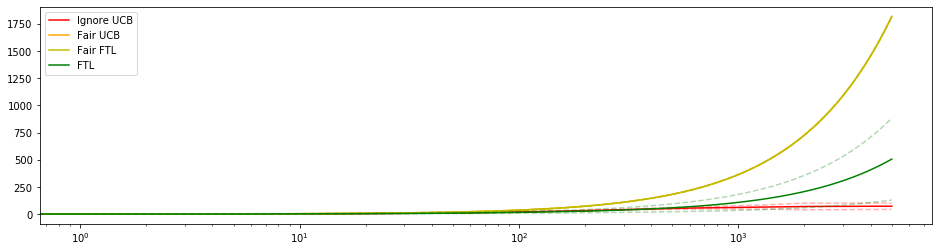

In [13]:
#%run sim_utilities.py
plot_and_save(data_dict, save_data=False, skip_algs=[])